 # 无散度谱投影 (Divergence-Free Spectral Projection)

 本示例演示了如何通过谱投影（spectral projection）方法，在二维速度场中强制满足无散度（divergence-free）约束。 无散度约束是流体力学等领域的核心约束（如不可压缩流体的连续性方程），谱投影是一种高效的数值方法来保证该约束。



 ## 导入依赖库

 首先导入核心的neuralop库（神经算子库）及其他必要的依赖包，neuralop是用于求解偏微分方程的神经算子库，提供了谱投影、微分计算等功能。



In [1]:
# 导入PyTorch（深度学习框架，用于张量计算）
import torch
# 导入NumPy（数值计算库，用于常量定义如π）
import numpy as np
# 导入matplotlib（绘图库，用于结果可视化）
import matplotlib.pyplot as plt
# 从neuralop导入无散度谱投影核心函数
from neuralop.layers.spectral_projection import spectral_projection_divergence_free
# 从neuralop导入两种微分计算方法：傅里叶微分（谱域）和有限差分（空域）
from neuralop.losses.differentiation import FourierDiff, FiniteDiff

# 设置计算设备：优先使用GPU（CUDA），若无则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 打印当前使用的设备，方便调试
print(f"使用设备: {device}")


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
使用设备: cpu


 ## 散度误差计算函数

 定义两个函数分别通过**谱微分（傅里叶微分）** 和**有限差分**计算速度场的散度误差， 散度误差是衡量速度场是否满足无散度约束的核心指标（误差越小，越接近无散度）。

具体来说，输入速度场 $\mathbf u = (u_x, u_y)$（离散化后形状为 `[批量大小, 2, 高度, 宽度]`） 和计算域的边长 $L = 2\pi$，我们计算速度场的散度 $\nabla \cdot \mathbf{u}$（返回在离散点处的值，因此是一个张量，形状为 `[批量大小, 高度, 宽度]`），然后计算散度的L2范数，并进行归一化处理（乘上归一化因子 $\frac{L}{\sqrt{\text{高度} \times \text{宽度}}}$）以消除分辨率对范数大小的影响，最后返回所有样本的平均误差作为最终结果。



In [2]:
def div_error_fourier(u, L):
    """
    基于谱微分（傅里叶微分）计算速度场的散度误差（L2范数）
    谱微分通过傅里叶变换将空域信号转换到谱域，在谱域计算导数后再逆变换回空域，
    相比有限差分具有更高的精度（尤其是低分辨率下）。
    
    参数:
        u (torch.Tensor): 二维速度场张量，形状为 [批量大小, 速度分量数, 高度, 宽度]
        L (float): 计算域的边长（本示例中为2π）
    
    返回:
        float: 平均散度误差（标量）
    """
    # 初始化二维傅里叶微分器，dim=2表示二维场，L=(L,L)表示x/y方向的计算域长度（离散点数），use_fc=False禁用Fourier延拓
    fourier_diff_2d = FourierDiff(dim=2, L=(L, L), use_fc=False)
    # 计算速度场u的散度：∇·u = ∂u_x/∂x + ∂u_y/∂y
    div = fourier_diff_2d.divergence(u)
    # 计算散度的L2范数（归一化）：
    # 1. torch.linalg.norm(div, dim=(1,2)): 对每个样本的空间维度（高度/宽度）计算L2范数
    # 2. (L²/(分辨率×分辨率))^0.5: 归一化因子，消除分辨率对范数大小的影响; .shape[-1] 表示倒数一维的元素个数；.shape[-2] 表示倒数第二维的元素个数
    error_val = torch.linalg.norm(div, dim=(1, 2)) * (L**2 / (div.shape[-1] * div.shape[-2]))**(0.5)
    # 返回所有样本的平均误差（转换为Python标量）
    return error_val.mean().item()
def div_error_finite_diff(u, L):
    """
    基于有限差分计算速度场的散度误差（L2范数）
    有限差分通过空域相邻点的差值近似导数（本示例使用中心差分），
    精度低于谱微分，但计算逻辑更直观，是传统的数值微分方法。
    
    参数:
        u (torch.Tensor): 二维速度场张量，形状为 [批量大小, 速度分量数, 高度, 宽度]
        L (float): 计算域的边长（本示例中为2π）
    
    返回:
        float: 平均散度误差（标量）
    """
    # 计算x/y方向的网格步长：dx = 计算域长度 / 分辨率
    dx = L / u.shape[-1]
    dy = L / u.shape[-2]
    # 初始化二维有限差分器：
    # - dim=2: 二维场
    # - h=(dx, dy): x/y方向的步长
    # - periodic_in_x/y=True: x/y方向均为周期边界（符合流体力学常见假设）
    finite_diff_2d = FiniteDiff(dim=2, h=(dx, dy), periodic_in_x=True, periodic_in_y=True)
    # 计算速度场u的散度
    div = finite_diff_2d.divergence(u)
    # 计算归一化的L2范数（与谱微分方法一致）
    error_val = torch.linalg.norm(div, dim=(1, 2)) * (L**2 / (div.shape[-1] * div.shape[-2]))**(0.5)
    # 返回平均误差
    return error_val.mean().item()


 ## 实验设置与核心流程

 实验核心步骤：

 1. 构造理论上严格无散度的二维速度场（基于流函数 $\phi(x,y) = \sin(x)\cos(6y)$）；

 2. 给速度场添加10%噪声，破坏其无散度特性；

 3. 应用谱投影方法，将含噪声的速度场投影回无散度空间；

 4. 在不同分辨率下，计算原始/含噪声/投影后速度场的散度误差；

 5. 验证谱投影方法能否有效恢复无散度约束。



 数学背景：

 - 流函数 $\phi$ 与速度场 $\mathbf{u}=(u_x, u_y)$ 的关系：$ u_x = \frac{\partial \phi}{\partial y}, u_y = -\frac{\partial \phi}{\partial x}$；

 - 无散度验证：$\nabla \cdot \mathbf{u} = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y} = 0$（理论上严格成立）。

In [3]:
# 计算域边长：[0, 2π] × [0, 2π]
L = 2 * np.pi
# 噪声水平：添加的噪声幅度为速度场平均幅值的10%
noise_level = 0.1
# 测试的分辨率列表（从256×256到8192×8192），验证方法在不同分辨率下的表现
resolutions = [256, 512, 1024, 2048, 4096, 8192]

# 初始化空列表，用于存储不同分辨率下的散度误差
# 谱微分计算的误差
errors_original_spectral = []  # 原始无散度场的误差
errors_noisy_spectral = []    # 含噪声场的误差
errors_prog_spectral = []     # 谱投影后场的误差
# 有限差分计算的误差
errors_original_finite = []   # 原始无散度场的误差
errors_noisy_finite = []      # 含噪声场的误差
errors_prog_finite = []       # 谱投影后场的误差

# 遍历所有分辨率，逐一生成数据并计算误差
for target_resolution in resolutions:
    # 1. 生成坐标网格（用于构造速度场）
    # xs/ys: 一维坐标数组，范围[0, 2π]，步长L/target_resolution
    xs = torch.arange(target_resolution, device=device, dtype=torch.float64) * (L / target_resolution)
    ys = torch.arange(target_resolution, device=device, dtype=torch.float64) * (L / target_resolution)
    # 生成二维网格（indexing="ij"表示矩阵索引，即(X[i,j], Y[i,j])对应第i行第j列）
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    
    # 2. 构造理论无散度的速度场（基于流函数ψ = sin(x)cos(6y)）
    # u_x = ∂ψ/∂y = -6sin(x)sin(6y)
    u_x = -6.0 * torch.sin(X) * torch.sin(6.0 * Y)
    # u_y = -∂ψ/∂x = -cos(x)cos(6y)
    u_y = -torch.cos(X) * torch.cos(6.0 * Y)
    # 拼接速度分量并扩展维度：
    # - stack([u_x, u_y], dim=0): 拼接为[2, H, W]（2个速度分量）
    # - unsqueeze(0): 添加批次维度，最终形状[1, 2, H, W]
    # - to(device): 移至指定设备（GPU/CPU），dtype=torch.float64使用高精度浮点数
    u = torch.stack([u_x, u_y], dim=0).unsqueeze(0).to(device=device, dtype=torch.float64)
    
    # 3. 添加噪声，破坏无散度特性
    # 计算速度场的平均幅值（用于归一化噪声，保证噪声幅度与速度场匹配）
    mean_magnitude = torch.mean(torch.sqrt(u[:, 0] ** 2 + u[:, 1] ** 2))
    # 生成高斯噪声：形状与u相同，幅度为mean_magnitude的10%
    noise = torch.randn_like(u, dtype=torch.float64) * noise_level * mean_magnitude
    # 含噪声的速度场
    u_noisy = u + noise

    # 4. 应用谱投影，恢复无散度约束
    # spectral_projection_divergence_free: 核心函数，将速度场投影到无散度空间
    # constraint_modes=(64,64): 谱投影的模态数，控制计算效率与精度
    u_proj = spectral_projection_divergence_free(u_noisy, L, constraint_modes=(64, 64))

    # 5. 计算三种速度场的散度误差（谱微分+有限差分）
    errors_original_spectral.append(div_error_fourier(u, L))          # 原始场（谱微分）
    errors_original_finite.append(div_error_finite_diff(u, L))        # 原始场（有限差分）
    errors_noisy_spectral.append(div_error_fourier(u_noisy, L))       # 含噪声场（谱微分）
    errors_noisy_finite.append(div_error_finite_diff(u_noisy, L))     # 含噪声场（有限差分）
    errors_prog_spectral.append(div_error_fourier(u_proj, L))         # 投影场（谱微分）
    errors_prog_finite.append(div_error_finite_diff(u_proj, L))       # 投影场（有限差分）


 ## 谱微分法的散度误差结果展示

 谱微分（傅里叶微分）在谱域计算导数，精度远高于有限差分（尤其是低分辨率下），

 能更准确地反映速度场的真实散度误差。

 我们通过表格和对数坐标图展示不同分辨率下的误差，验证谱投影的效果。



Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


-------------------------------------------------------
分辨率          原始场             含噪声场            投影场            
-------------------------------------------------------
256          1.50e-06        1.68e+02        9.20e-07       
512          1.50e-06        3.38e+02        9.12e-07       
1024         1.50e-06        6.76e+02        9.10e-07       
2048         1.50e-06        1.35e+03        9.10e-07       
4096         1.50e-06        2.71e+03        9.10e-07       
8192         1.50e-06        5.42e+03        9.10e-07       


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


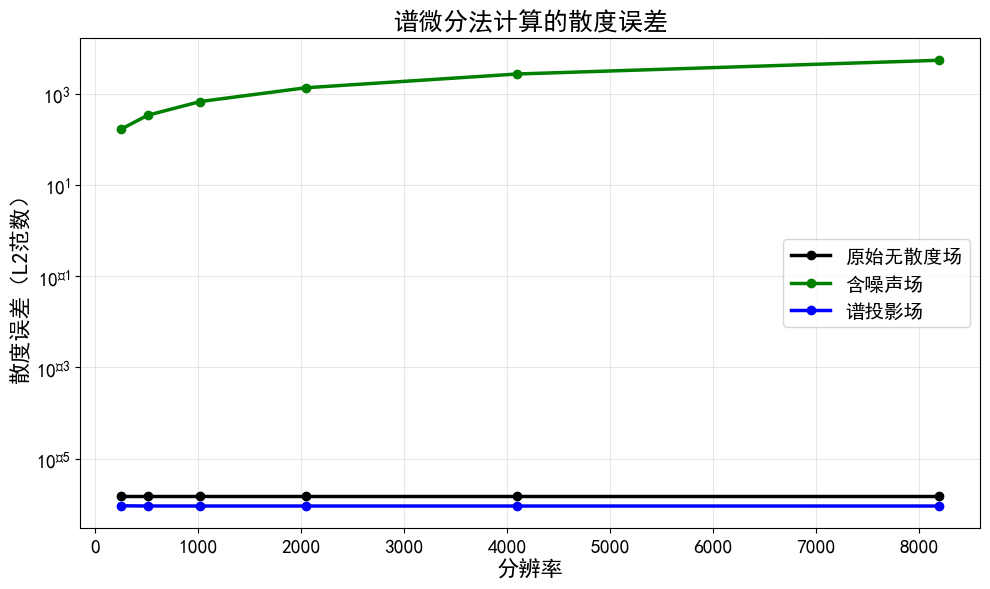

In [4]:
# 打印谱微分误差的表格
print("-" * 55)
# 表头：分辨率、原始场误差、含噪声场误差、投影场误差
print(f"{'分辨率':<12} {'原始场':<15} {'含噪声场':<15} {'投影场':<15}")
print("-" * 55)

# 遍历分辨率和对应误差，格式化输出（科学计数法，保留2位小数）
for i, res in enumerate(resolutions):
    print(
        f"{res:<12} {errors_original_spectral[i]:<15.2e} {errors_noisy_spectral[i]:<15.2e} {errors_prog_spectral[i]:<15.2e}"
    )

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 绘制谱微分误差的对数坐标图（y轴对数，便于观察误差的数量级变化）
plt.figure(figsize=(10, 6))  # 设置图的尺寸
# 原始场误差：黑色，圆圈标记+实线，线宽2.5，标记大小6
plt.semilogy(resolutions, errors_original_spectral, "o-", label="原始无散度场", color="black", linewidth=2.5, markersize=6)
# 含噪声场误差：绿色
plt.semilogy(resolutions, errors_noisy_spectral, "o-", label="含噪声场", color="green", linewidth=2.5, markersize=6)
# 投影场误差：蓝色
plt.semilogy(resolutions, errors_prog_spectral, "o-", label="谱投影场", color="blue", linewidth=2.5, markersize=6)
# 设置坐标轴标签和标题（字体大小优化）
plt.xlabel("分辨率", fontsize=16)
plt.ylabel("散度误差（L2范数）", fontsize=16)
plt.title("谱微分法计算的散度误差", fontsize=18)
# 添加图例、网格，优化刻度字体
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)  # alpha=0.3：网格半透明，不遮挡曲线
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# 自动调整布局，避免标签重叠
plt.tight_layout()
# 显示图像
plt.show()


 ## 有限差分法的散度误差结果展示

 有限差分法通过空域相邻点差值近似导数，低分辨率下精度较低（误差偏大）， 但随分辨率提升，误差会逐渐收敛到真实值。 我们同样通过表格和绘图展示结果，对比谱微分的差异。



Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

-------------------------------------------------------
分辨率          原始场             含噪声场            投影场            
-------------------------------------------------------
256          6.62e-02        6.58e+01        1.64e-01       
512          1.66e-02        1.32e+02        2.55e-02       
1024         4.14e-03        2.64e+02        4.82e-03       
2048         1.03e-03        5.28e+02        1.08e-03       
4096         2.59e-04        1.06e+03        2.61e-04       
8192         6.47e-05        2.11e+03        6.43e-05       


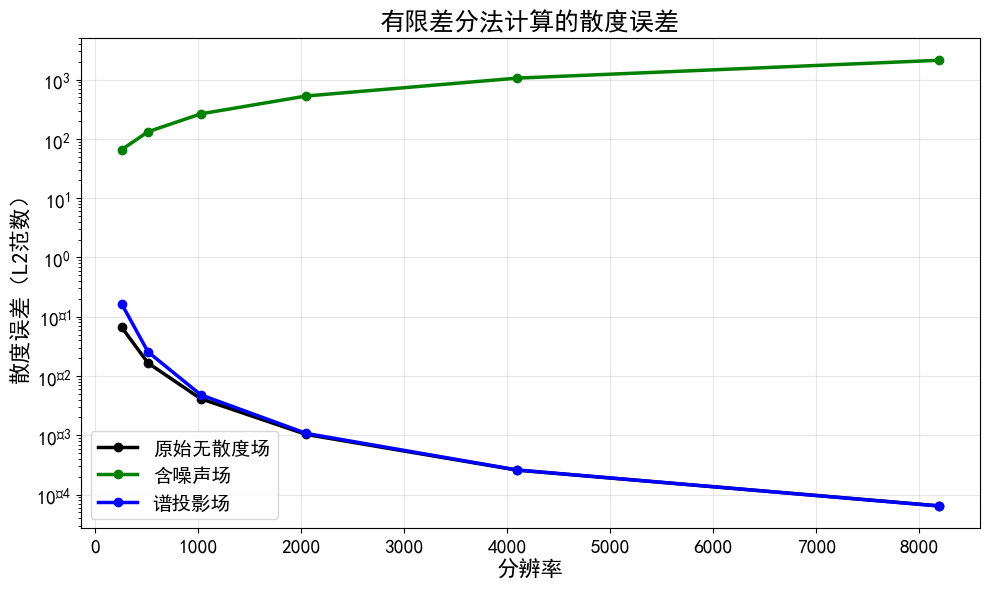

In [5]:
# 打印有限差分误差的表格
print("-" * 55)
print(f"{'分辨率':<12} {'原始场':<15} {'含噪声场':<15} {'投影场':<15}")
print("-" * 55)

# 遍历分辨率和对应误差，格式化输出
for i, res in enumerate(resolutions):
    print(
        f"{res:<12} {errors_original_finite[i]:<15.2e} {errors_noisy_finite[i]:<15.2e} {errors_prog_finite[i]:<15.2e}"
    )

# 绘制有限差分误差的对数坐标图
plt.figure(figsize=(10, 6))
plt.semilogy(resolutions, errors_original_finite, "o-", label="原始无散度场", color="black", linewidth=2.5, markersize=6)
plt.semilogy(resolutions, errors_noisy_finite, "o-", label="含噪声场", color="green", linewidth=2.5, markersize=6)
plt.semilogy(resolutions, errors_prog_finite, "o-", label="谱投影场", color="blue", linewidth=2.5, markersize=6)
# 设置坐标轴和标题
plt.xlabel("分辨率", fontsize=16)
plt.ylabel("散度误差（L2范数）", fontsize=16)
plt.title("有限差分法计算的散度误差", fontsize=18)
# 优化可视化
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()